# COMP 562 - Machine Learning Final Project
## Plan

Our goal is to distinguish between tweets which are about real disasters and those which are about fake, metaphorical, or otherwise not real ones.
### Turning tweets into features

- Start with trigrams, can tune later
- Can consider bigrams, bag of words, or other n-grams
- Ignore location information, at least for now
- Almost all tweets have keywords, use as another feature
- Make sure to process "keyword" values, removing special characters

### Criteria for disaster
- Meant to track if tweets are referring to ongoing disasters
- Also includes historical events


### Training
- Train and validate our model on `train.csv` 
- Test by sending results to Kaggle

### Random forest
- Use Gini criterion for efficiency

### Neural networks
- Use multi-layer perceptron classifier
- Tweak alpha values

## Disaster tweet classification
### Important modules

In [17]:
import numpy as np
import pandas as pd
import string, re

### Importing data

In [18]:
train_df = pd.read_csv("disaster-tweets/data/train.csv")
test_df = pd.read_csv("disaster-tweets/data/test.csv")

### Finding all characters in dataset

In [19]:
def standardize_string(s):
    s = s.lower()
    s = re.sub("http://t\.co/\S+", "", s)
    return s

In [20]:
all_characters = set()

for tweet in train_df['text']:
    all_characters = all_characters.union(set(standardize_string(tweet)))

char_list = list(all_characters)
char_list.sort()
print(char_list)

['\n', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x89', '\x9d', '¡', '¢', '£', '¤', '¨', '©', 'ª', '«', '¬', '´', '¼', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', '÷', 'û', 'ü']


### Narrowing down characters

We decided that from these characters, we would only keep letters, numbers, and a few accented characters. We also kept '#' and '@' due to their importance on Twitter.

In [21]:
included_chars = list(string.ascii_lowercase + string.digits) + ['#', '@', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', 'ü', ' ']
print(included_chars)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '#', '@', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', 'ü', ' ']


### Removing invalid characters
- Try both with and without removing special characters
- Consider skipping data points with bad characters

In [22]:
def remove_special_characters(s):
    for c in char_list:
        if c not in included_chars:
            s = s.replace(c, "")
    return s

def format_tweet(t):
    # Makes lowercase
    formatted_tweet = t.lower()
    # Removed links
    formatted_tweet = re.sub(" http(s|)://t\.co/\S+", "", formatted_tweet)
    formatted_tweet = re.sub("http(s|)://t\.co/\S+", "", formatted_tweet)
    # Removes any special characters, other than a-z, numbers, spaces, hashtags, and @
    formatted_tweet = remove_special_characters(formatted_tweet)
    final_tweet_array = []
    
    # Removes multiple consecutive spaces
    for i, char in enumerate(formatted_tweet):
        if i == 0:
            if char != ' ':
                final_tweet_array.append(char)
                continue
        prev_char = formatted_tweet[i-1]
        if char == ' ' and prev_char == ' ':
            continue
        final_tweet_array.append(char)
    final_tweet = "".join(final_tweet_array)
    return final_tweet

In [23]:
formatted_train_tweets = []
for i, tweet in enumerate(train_df["text"]):
    formatted_train_tweets.append(format_tweet(tweet))

formatted_test_tweets = []
for tweet in test_df["text"]:
    formatted_test_tweets.append(format_tweet(tweet))
    
test_ids = test_df['id']

### Splitting tweets into bigrams

Tweets were processed into bigram representations, which includes information about two consecutive words at a time.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_train = bigram_vectorizer.fit_transform(formatted_train_tweets)
bigram_test = bigram_vectorizer.transform(formatted_test_tweets)

In [25]:
# 1-gram no string formatting
# array([0.55543823, 0.50891089, 0.54221388, 0.51913133, 0.68794326])
# 1 and 2-gram, no string formatting
# array([0.46118721, 0.45027322, 0.43412527, 0.44141069, 0.61523626])
# 1-gram basic string formatting
# array([0.57556936, 0.48219736, 0.5530303 , 0.51859504, 0.68586387])
# 1 & 2-gram, basic string formatting
# array([0.5039019 , 0.41150442, 0.41241685, 0.45823928, 0.62327416])
# bigram only, basic string formatting
# array([0.24096386, 0.25725095, 0.1682243 , 0.17475728, 0.31060606])

### Random forest classifier
#### Creating the model

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_jobs=10, max_depth=None, class_weight="balanced")

#### Cross-validation

In [ ]:
rf_parameters = {
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 4),
    'n_estimators': [50, 100, 500]
}

rf_cv = GridSearchCV(rf, rf_parameters, verbose=4, n_jobs=8)
rf_cv.fit(bigram_train, train_df['target'])
print(rf_cv.best_params_)

# {'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}
# {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1}

In [27]:
rf_best = RandomForestClassifier(n_jobs=10, max_depth=None, class_weight="balanced", min_samples_leaf=2, min_samples_split=4, n_estimators=500)
rf_best.fit(bigram_train, train_df['target'])

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=500, n_jobs=10)

Initially, we did cross-validation across maximum depth and number of estimators. However, these models all gave fairly poor accuracy. Instead, we switched to cross-validation across minimum samples for a split and minimum samples for a leaf. These hyperparameters allowed us to get better results. Through this second round of cross validation, we got the hyperparameters with the highest average accuracy as:

`{'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}`

#### Predicting test data

As the disaster tweets dataset is from a Kaggle competition, the creators chose to not make the test labels public. As such, we have the random forest model make predictions on the test data. We then submitted this data to Kaggle to get an accuracy.

In [28]:
rf_predicted_classes = rf_best.predict(bigram_test)
print(rf_predicted_classes)
rf_out_array = []
for i, pred_class in enumerate(rf_predicted_classes):
    rf_out_array.append([int(test_ids[i]), pred_class])

np.savetxt("disaster-tweets/rf-results.csv", rf_out_array, delimiter=',', fmt='%i')

[0 0 1 ... 1 1 1]


According to Kaggle, these parameters gave an F1 score of `0.74103`.

### Multilayer perceptron classifier
#### Creating the model

In [15]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(verbose=True, tol=.001)

#### Cross-validation

In [ ]:
mlpc_parameters = {
    "alpha": [.0001, .001, .01, .1]
}
mlpc_cv = GridSearchCV(mlpc, mlpc_parameters, verbose=3, n_jobs=-1)
mlpc_cv.fit(bigram_train, train_df['target'])
print(mlpc_cv.best_params_)

In [16]:
mlpc_best = MLPClassifier(verbose=True, alpha=0.0001)
mlpc_best.fit(bigram_train, train_df['target'])

Iteration 1, loss = 0.65378585
Iteration 2, loss = 0.38417795
Iteration 3, loss = 0.17132882
Iteration 4, loss = 0.09669431
Iteration 5, loss = 0.07079079
Iteration 6, loss = 0.05829515
Iteration 7, loss = 0.05056332
Iteration 8, loss = 0.04617903
Iteration 9, loss = 0.04246392
Iteration 10, loss = 0.03958015
Iteration 11, loss = 0.03803645
Iteration 12, loss = 0.03739887
Iteration 13, loss = 0.03692402
Iteration 14, loss = 0.03558247


/Users/max/.pyenv/versions/3.10.2/envs/machine-learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(verbose=True)

Through cross-validation, we determined that the best value for the regularization parameter $\alpha$ was `0.0001`.

#### Predicting test data

In [71]:
mlpc_predicted_classes = mlpc_best.predict(bigram_test)
mlpc_out_array = []
for i, pred_class in enumerate(mlpc_predicted_classes):
    mlpc_out_array.append([int(test_ids[i]), pred_class])
    
np.savetxt("disaster-tweets/mlpc-results.csv", mlpc_out_array, delimiter=',', fmt='%i')

This value gave an accuracy on the test set of `0.76156`.

#### Retrying with tri-grams

Due to undesirably low accuracy, we tried to train a multilayer perceptron classifier again, this time with tweet data represented as tri-grams rather than bi-grams.

In [160]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3))
trigram_train = trigram_vectorizer.fit_transform(formatted_train_tweets)
trigram_test = trigram_vectorizer.transform(formatted_test_tweets)

mlpc_cv.fit(trigram_train, train_df['target'])
print(mlpc_cv.best_params_)

NameError: name 'mlpc_cv' is not defined

In [69]:
mlpc_best_3 = MLPClassifier(verbose=True, alpha=0.0001)
mlpc_best_3.fit(trigram_train, train_df['target'])

Iteration 1, loss = 0.65998443
Iteration 2, loss = 0.41289009
Iteration 3, loss = 0.17760911
Iteration 4, loss = 0.10006627
Iteration 5, loss = 0.07405387
Iteration 6, loss = 0.06226100
Iteration 7, loss = 0.05525495
Iteration 8, loss = 0.05076233
Iteration 9, loss = 0.04792994
Iteration 10, loss = 0.04480943
Iteration 11, loss = 0.04329274
Iteration 12, loss = 0.04095148
Iteration 13, loss = 0.03921604
Iteration 14, loss = 0.03861391
Iteration 15, loss = 0.03697836
Iteration 16, loss = 0.03729102
Iteration 17, loss = 0.03674639
Iteration 18, loss = 0.03673427
Iteration 19, loss = 0.03671605
Iteration 20, loss = 0.03641200
Iteration 21, loss = 0.03623676
Iteration 22, loss = 0.03610162
Iteration 23, loss = 0.03578941
Iteration 24, loss = 0.03543862
Iteration 25, loss = 0.03476308
Iteration 26, loss = 0.03405999
Iteration 27, loss = 0.03391983
Iteration 28, loss = 0.03463444
Iteration 29, loss = 0.03388752
Iteration 30, loss = 0.03609107
Iteration 31, loss = 0.03523457
Iteration 32, los

MLPClassifier(verbose=True)

Unfortunately, this actually diminished the accuracy, classifying `0.70303` of the results correctly.

In [70]:
mlpc_trigram_predicted_classes = mlpc_best_3.predict(trigram_test)
mlpc_trigram_out_array = []
for i, pred_class in enumerate(mlpc_trigram_predicted_classes):
    mlpc_trigram_out_array.append([int(test_ids[i]), pred_class])
    
np.savetxt("disaster-tweets/mlpc-trigam-results.csv", mlpc_trigram_out_array, delimiter=',', fmt='%i')

## Humor detection

After manual inspection and additional research on the disaster tweets dataset, we determined that the dataset itself was low quality, i.e. a number of the tweets were labeled incorrectly or did not in fact refer to a disaster of any kind. Instead, we decided to apply similar natural language techniques to another dataset. We found a dataset of 200,000 short passages of text (similar to tweets) which are labeled as either having humor or not having humor. Others' work on Kaggle gave us the impression that this dataset is high quality. We then proceeded much as before on this dataset.

https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection

### Important modules

In [83]:
import numpy as np
import pandas as pd

### Importing data

We decided to train on only 10 percent of the data, as there are 200,000 data points. Training on, for example, 60 percent of the data would take prohibitively long (more than 10 minutes for one fit). However, evaluation time is more reasonable than training time, so we can still test on the remaining 90 percent of the data.

In [84]:
from sklearn.model_selection import train_test_split

all_text = pd.read_csv("humor-dataset.csv")["text"]
all_humor = pd.read_csv("humor-dataset.csv")["humor"]

text_train, text_test, humor_train, humor_test = train_test_split(all_text, all_humor, train_size=.1)

### Making bi-grams

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_train = bigram_vectorizer.fit_transform(text_train)
bigram_test = bigram_vectorizer.transform(text_test)

### Random forest classifier
#### Making the model

In [86]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=None, class_weight="balanced", n_jobs=8, verbose=3)

#### Cross-validation

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_params = {
    'n_estimators': [50, 100, 500]
}

rf_cv = GridSearchCV(rf, rf_params, n_jobs=8, verbose=3)
rf_cv.fit(bigram_train, humor_train)
print(rf_cv.best_params_)

In [25]:
rf_best = RandomForestClassifier(max_depth=None, class_weight="balanced", n_jobs=8, verbose=3, n_estimators=500)
rf_best.fit(bigram_train, humor_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500building tree 2 of 500

building tree 3 of 500building tree 4 of 500building tree 5 of 500


building tree 6 of 500
building tree 7 of 500building tree 8 of 500

building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s


building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66

[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    5.0s


building tree 123 of 500
building tree 124 of 500building tree 125 of 500

building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500


[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   11.7s


building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500building tree 304 of 500

building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   20.9s finished


RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=8,
                       verbose=3)

Cross validation yielded a best n_estimators value of `500`.

#### Evaluation

The humor dataset, unlike the disaster tweets dataset, included labels for every piece of text in the dataset. As such, we are able to directly compute accuracy/F1 scores and also to plot confusion matrices.

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

def get_cm(preds):
    return confusion_matrix(humor_test, preds, labels=[False, True], normalize='all')

def plot_confusion_matrix(cm, title):
    fx = sb.heatmap(cm, annot=True, cmap='turbo')

    # labels the title and x, y axis of plot
    fx.set_title(title + '\n\n');
    fx.set_xlabel('Predicted Values')
    fx.set_ylabel('Actual Values ');

    # labels the boxes
    fx.xaxis.set_ticklabels(['False','True'])
    fx.yaxis.set_ticklabels(['False','True'])

    plt.show()

#### Confusion matrix and accuracy

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   34.2s finished


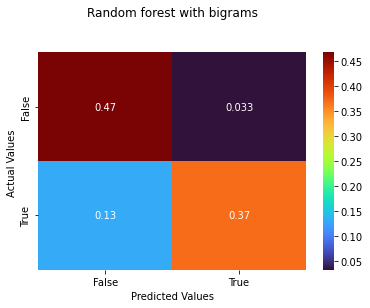

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   34.6s finished


0.8364222222222222

In [27]:
humor_preds = rf_best.predict(bigram_test)
rf_cm = get_cm(humor_preds)
plot_confusion_matrix(rf_cm, "Random forest with bigrams")
rf_best.score(bigram_test, humor_test)

A random forest classifier on the humor data was fairly effective, getting an accuracy of `0.836`.

### Multilayer perceptron classifier
#### Making the model

In [28]:
from sklearn.neural_network import MLPClassifier
mlpc_bigram = MLPClassifier(tol=.001, verbose=True)

#### Cross-validation

In [ ]:
mlpc_params = {
    "alpha": [.0001, .001, .01, .1]
}
print("Starting CV...")
mlpc_bigram_cv = GridSearchCV(mlpc_bigram, mlpc_params, verbose=3, n_jobs=8)
mlpc_bigram_cv.fit(bigram_train, humor_train)

In [54]:
mlpc_bigram_best = MLPClassifier(verbose=True, alpha=.0001)
mlpc_bigram_best.fit(bigram_train, humor_train)

Iteration 1, loss = 0.51412902
Iteration 2, loss = 0.11129034
Iteration 3, loss = 0.02204684
Iteration 4, loss = 0.00967782
Iteration 5, loss = 0.00587338
Iteration 6, loss = 0.00414463
Iteration 7, loss = 0.00320636
Iteration 8, loss = 0.00263274
Iteration 9, loss = 0.00225480
Iteration 10, loss = 0.00199200
Iteration 11, loss = 0.00180313
Iteration 12, loss = 0.00166144
Iteration 13, loss = 0.00155285
Iteration 14, loss = 0.00146746
Iteration 15, loss = 0.00139861
Iteration 16, loss = 0.00134209
Iteration 17, loss = 0.00129482
Iteration 18, loss = 0.00125467
Iteration 19, loss = 0.00121995
Iteration 20, loss = 0.00118951
Iteration 21, loss = 0.00116233
Iteration 22, loss = 0.00113767
Iteration 23, loss = 0.00111515
Iteration 24, loss = 0.00109429
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(verbose=True)

Cross validation yielded a best regularization value of $\alpha = 0.0001$.

#### Confusion matrix and accuracy

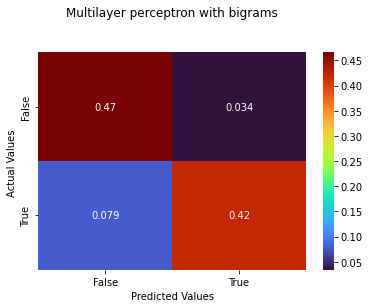

0.8868166666666667

In [30]:
humor_preds = mlpc_bigram_best.predict(bigram_test)
mlpc_cm = get_cm(humor_preds)
plot_confusion_matrix(mlpc_cm, "Multilayer perceptron with bigrams")
mlpc_bigram_best.score(bigram_test, humor_test)

The multilayer perceptron classifier fared even better, getting an accuracy of `0.887` on the test data.

### Retrying with trigrams
#### Making the trigrams

In [31]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3))
trigram_train = trigram_vectorizer.fit_transform(text_train)
trigram_test = trigram_vectorizer.transform(text_test)

### Multilayer perceptron classifier with trigrams

In [57]:
mlpc_trigram_best = MLPClassifier(verbose=True, alpha=.0001)
mlpc_trigram_best.fit(trigram_train, humor_train)

Iteration 1, loss = 0.62316569
Iteration 2, loss = 0.14217922
Iteration 3, loss = 0.01728786
Iteration 4, loss = 0.00850960
Iteration 5, loss = 0.00552305
Iteration 6, loss = 0.00407609
Iteration 7, loss = 0.00325284
Iteration 8, loss = 0.00274001
Iteration 9, loss = 0.00239860
Iteration 10, loss = 0.00216048
Iteration 11, loss = 0.00198673
Iteration 12, loss = 0.00185710
Iteration 13, loss = 0.00175679
Iteration 14, loss = 0.00167770
Iteration 15, loss = 0.00161387
Iteration 16, loss = 0.00156128
Iteration 17, loss = 0.00151720
Iteration 18, loss = 0.00147946
Iteration 19, loss = 0.00144660
Iteration 20, loss = 0.00141749
Iteration 21, loss = 0.00139126
Iteration 22, loss = 0.00136731
Iteration 23, loss = 0.00134508
Iteration 24, loss = 0.00132422
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(verbose=True)

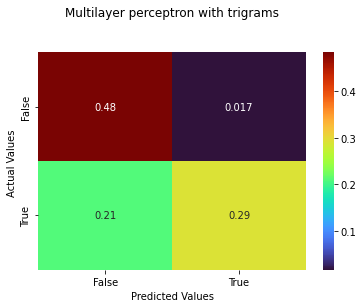

0.7737666666666667

In [33]:
humor_preds = mlpc_trigram_best.predict(trigram_test)
mlpc_cm = get_cm(humor_preds)
plot_confusion_matrix(mlpc_cm, "Multilayer perceptron with trigrams")
mlpc_trigram_best.score(trigram_test, humor_test)

Interestingly, the MLP classifier performed significantly worse when trained on only trigrams, giving an accuracy of `0.774`. Note, however, that it's performance on fake disaster tweets was excellent, while its performance on true disaster tweets was only slightly better than chance.

### Retrying with multigrams
What if, instead, we trained on single words, bigrams, and trigrams at the same time?
#### Making the multigrams

In [35]:
multigram_vectorizer = CountVectorizer(ngram_range=(1,3))
multigram_train = multigram_vectorizer.fit_transform(text_train)
multigram_test = multigram_vectorizer.transform(text_test)

In [36]:
mlpc_multigram_best = MLPClassifier(verbose=True, alpha=.0001)
mlpc_multigram_best.fit(multigram_train, humor_train)

Iteration 1, loss = 0.35605639
Iteration 2, loss = 0.03077900
Iteration 3, loss = 0.00640508
Iteration 4, loss = 0.00346172
Iteration 5, loss = 0.00242445
Iteration 6, loss = 0.00191150
Iteration 7, loss = 0.00160671
Iteration 8, loss = 0.00140913
Iteration 9, loss = 0.00127199
Iteration 10, loss = 0.00117132
Iteration 11, loss = 0.00109489
Iteration 12, loss = 0.00103432
Iteration 13, loss = 0.00098510
Iteration 14, loss = 0.00094378
Iteration 15, loss = 0.00090839
Iteration 16, loss = 0.00087729
Iteration 17, loss = 0.00084948
Iteration 18, loss = 0.00082431
Iteration 19, loss = 0.00080109
Iteration 20, loss = 0.00077955
Iteration 21, loss = 0.00075937
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(verbose=True)

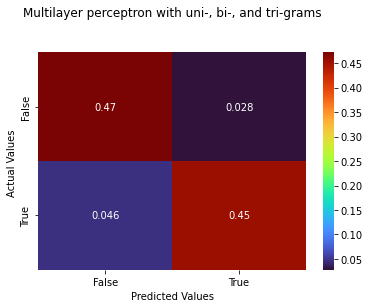

0.9260388888888889

In [37]:
humor_preds = mlpc_multigram_best.predict(multigram_test)
mlpc_cm = get_cm(humor_preds)
plot_confusion_matrix(mlpc_cm, "Multilayer perceptron with uni-, bi-, and tri-grams")
mlpc_multigram_best.score(multigram_test, humor_test)

Using, 1, 2, and 3-grams, we were able to achieve better accuracy than with any previous method, getting `0.926`. Unfortunately, it would take prohibitively long to cross-validate on additional parameters for the multigrams, as it took 15 minutes to train on a single set of parameters.

### Larger multigrams

In [38]:
large_multigram_vectorizer = CountVectorizer(ngram_range=(1,5))
large_multigram_train = large_multigram_vectorizer.fit_transform(text_train)
large_multigram_test = large_multigram_vectorizer.transform(text_test)

In [39]:
mlpc_large_multigram_best = MLPClassifier(verbose=True, alpha=.0001)
mlpc_large_multigram_best.fit(multigram_train, humor_train)

Iteration 1, loss = 0.35516254
Iteration 2, loss = 0.01459257
Iteration 3, loss = 0.00394896
Iteration 4, loss = 0.00253989
Iteration 5, loss = 0.00193782
Iteration 6, loss = 0.00165287
Iteration 7, loss = 0.00147523
Iteration 8, loss = 0.00135158
Iteration 9, loss = 0.00125927
Iteration 10, loss = 0.00118751
Iteration 11, loss = 0.00112787
Iteration 12, loss = 0.00107836
Iteration 13, loss = 0.00103549
Iteration 14, loss = 0.00099697
Iteration 15, loss = 0.00096255
Iteration 16, loss = 0.00093100
Iteration 17, loss = 0.00090171
Iteration 18, loss = 0.00087437
Iteration 19, loss = 0.00084846
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(verbose=True)

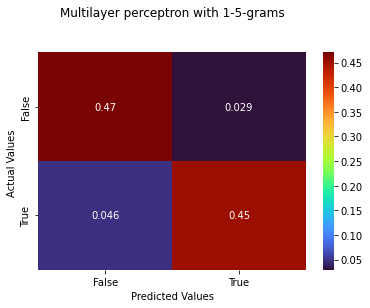

0.9244722222222223

In [40]:
humor_preds = mlpc_large_multigram_best.predict(multigram_test)
mlpc_cm = get_cm(humor_preds)
plot_confusion_matrix(mlpc_cm, "Multilayer perceptron with 1-5-grams")
mlpc_large_multigram_best.score(multigram_test, humor_test)

Running on 1-, 2-, 3-, 4-, and 5-grams gave a very similar accuracy of `0.924`. Thus, it does not seems wise to incorporate this information as it causes much longer training times.

### Giving weights to n-grams

Instead, we will train MLP classifiers on one through three-grams, weighting the outputs of the models variously according to three hyperparameters.

#### Monogram model

In [44]:
monogram_vectorizer = CountVectorizer(ngram_range=(1,1))
monogram_train = monogram_vectorizer.fit_transform(text_train)
monogram_test = monogram_vectorizer.transform(text_test)

In [46]:
mlpc_monogram_best = MLPClassifier(verbose=True, alpha=.0001)
mlpc_monogram_best.fit(monogram_train, humor_train)

Iteration 1, loss = 0.39520378
Iteration 2, loss = 0.17308759
Iteration 3, loss = 0.11153408
Iteration 4, loss = 0.07746104
Iteration 5, loss = 0.05529368
Iteration 6, loss = 0.04082344
Iteration 7, loss = 0.03082222
Iteration 8, loss = 0.02340932
Iteration 9, loss = 0.01823927
Iteration 10, loss = 0.01427790
Iteration 11, loss = 0.01160706
Iteration 12, loss = 0.00941678
Iteration 13, loss = 0.00772076
Iteration 14, loss = 0.00652531
Iteration 15, loss = 0.00560388
Iteration 16, loss = 0.00484164
Iteration 17, loss = 0.00424552
Iteration 18, loss = 0.00375930
Iteration 19, loss = 0.00341552
Iteration 20, loss = 0.00310447
Iteration 21, loss = 0.00284776
Iteration 22, loss = 0.00261333
Iteration 23, loss = 0.00244034
Iteration 24, loss = 0.00228508
Iteration 25, loss = 0.00214779
Iteration 26, loss = 0.00203234
Iteration 27, loss = 0.00193669
Iteration 28, loss = 0.00185300
Iteration 29, loss = 0.00176936
Iteration 30, loss = 0.00169949
Iteration 31, loss = 0.00163836
Iteration 32, los

MLPClassifier(verbose=True)

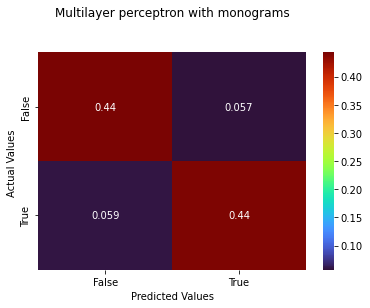

0.8838111111111111

In [49]:
humor_preds = mlpc_monogram_best.predict(monogram_test)
mlpc_cm = get_cm(humor_preds)
plot_confusion_matrix(mlpc_cm, "Multilayer perceptron with monograms")
mlpc_monogram_best.score(monogram_test, humor_test)

Note that the monogram model gave an accuracy of `0.884`. Now, we will combine the predictions of these three pre-trained models together.

In [62]:
def combination_model(X, monogram_weight=1, bigram_weight=1, trigram_weight=1):
    monograms = None
    bigrams = None
    trigrams = None
    monograms = monogram_vectorizer.transform(X)
    bigrams = bigram_vectorizer.transform(X)
    trigrams = trigram_vectorizer.transform(X)

    monogram_prediction = mlpc_monogram_best.predict(monograms)
    bigram_prediction = mlpc_bigram_best.predict(bigrams)
    trigram_prediction = mlpc_trigram_best.predict(trigrams)
    monogram_ints = [int(b) for b in monogram_prediction]
    bigram_ints = [int(b) for b in bigram_prediction]
    trigram_ints = [int(b) for b in trigram_prediction]

    combined_ints = []
    for i, v in enumerate(monogram_ints):
        combined_int = np.round((monogram_ints[i]*monogram_weight + bigram_ints[i]*bigram_weight + trigram_ints[i]*trigram_weight)/(monogram_weight + bigram_weight + trigram_weight))
        combined_ints.append(combined_int)

    combined_predictions = [bool(i) for i in combined_ints]
    return combined_predictions

    

print(combination_model(text_test))

[False, False, False, True, True, True, False, True, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, True, True, False, True, False, False, False, True, False, True, True, True, False, True, True, True, False, True, False, True, False, False, True, False, True, False, True, False, False, True, True, False, False, True, False, False, False, True, True, False, True, False, False, False, False, True, False, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, False, True, True, False, False, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, False, True, True, False, False, False, False, True, False, True, False, True, False, False, False, True, True, False, True, True, False, True, True, False, True, True, False, False, True, False, True, True, False, False, False, 

As each of these n-gram models are pre-trained on the training data, we need to further split the test data into "training" and "test" data. These "training" data will be used to evaluate the accuracy of the combined model on a particular set of weights, while the "test" data will be used to score the best set of weights after the fact.

In [63]:
combo_text_train, combo_text_test, combo_humor_train, combo_humor_test = train_test_split(text_test, humor_test, train_size=.75)

In [85]:
def get_combo_cm(preds):
    return confusion_matrix(combo_humor_test, preds, labels=[False, True], normalize='all')

In [70]:
from sklearn.metrics import accuracy_score

def get_combo_train_accuracy(preds):
    return accuracy_score(combo_humor_train, preds)

We iterate through many different weight combination and find the one with highest accuracy.

In [82]:
import itertools

best_weights = []
best_accuracy = 0

for monogram_weight, bigram_weight, trigram_weight in itertools.product(range(1, 6), range(1, 6), range(1, 6)):
    combo_humor_preds = combination_model(combo_text_train, monogram_weight=monogram_weight, bigram_weight=bigram_weight, trigram_weight=trigram_weight)
    accuracy = get_combo_train_accuracy(combo_humor_preds)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = [monogram_weight, bigram_weight, trigram_weight]
    print(str([monogram_weight, bigram_weight, trigram_weight]) + ": " + str(accuracy))

print("Best was: " + str(best_weights) + " with an accuracy of " + str(best_accuracy))

[1, 1, 1]: 0.8888370370370371
[1, 1, 2]: 0.7834962962962962
[1, 1, 3]: 0.7776296296296297
[1, 1, 4]: 0.7776296296296297
[1, 1, 5]: 0.7776296296296297
[1, 2, 1]: 0.8857925925925926
[1, 2, 2]: 0.8888370370370371
[1, 2, 3]: 0.7834962962962962
[1, 2, 4]: 0.7776296296296297
[1, 2, 5]: 0.7776296296296297
[1, 3, 1]: 0.8875555555555555
[1, 3, 2]: 0.8857925925925926
[1, 3, 3]: 0.8888370370370371
[1, 3, 4]: 0.7834962962962962
[1, 3, 5]: 0.7776296296296297
[1, 4, 1]: 0.8875555555555555
[1, 4, 2]: 0.8875555555555555
[1, 4, 3]: 0.8857925925925926
[1, 4, 4]: 0.8888370370370371
[1, 4, 5]: 0.7834962962962962
[1, 5, 1]: 0.8875555555555555
[1, 5, 2]: 0.8875555555555555
[1, 5, 3]: 0.8875555555555555
[1, 5, 4]: 0.8857925925925926
[1, 5, 5]: 0.8888370370370371
[2, 1, 1]: 0.8792222222222222
[2, 1, 2]: 0.8888370370370371
[2, 1, 3]: 0.7834962962962962
[2, 1, 4]: 0.7776296296296297
[2, 1, 5]: 0.7776296296296297
[2, 2, 1]: 0.8888370370370371
[2, 2, 2]: 0.8888370370370371
[2, 2, 3]: 0.8888370370370371
[2, 2, 4]:

In [1]:
combo_humor_preds = combination_model(combo_text_test)
test_accuracy = accuracy_score(combo_humor_test, combo_humor_preds)
print(test_accuracy)
combo_humor_cm = get_combo_cm(combo_humor_preds)
plot_confusion_matrix(combo_humor_cm, "Multilayer perceptron with weighted 1-3-grams")

NameError: name 'combination_model' is not defined

Ultimately this was not very successful, giving an accuracy of `0.890`. We believe this is because combining the three n-gram predictions together loses information, and the weighting of the n-grams was already done by the previous neural network models.

# Visualizing n-grams

We would like to make the following visualizations:
- Disaster tweets
    - How effective were different methods?
    - Most common words in real disaster tweets
    - Most common words in fake disaster tweets
    - Words most likely to distinguish real/fake disasters

In [116]:
colors = ['pink', 'paleturquoise', 'palegreen', 'plum', 'khaki']

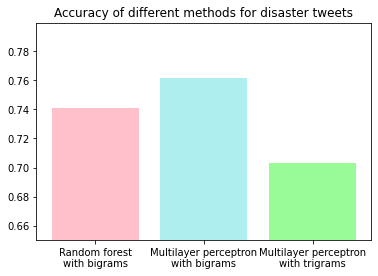

In [117]:
plt.bar(["Random forest\nwith bigrams", "Multilayer perceptron\nwith bigrams", "Multilayer perceptron\nwith trigrams"], [0.74103, 0.76156, 0.70303], color=colors[:3])
plt.ylim(bottom=.65)
plt.title("Accuracy of different methods for disaster tweets")
plt.show()

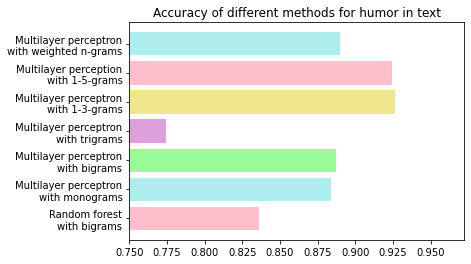

In [159]:
plt.barh(["Random forest\nwith bigrams", "Multilayer perceptron\nwith monograms", "Multilayer perceptron\nwith bigrams", "Multilayer perceptron\nwith trigrams", "Multilayer perceptron\nwith 1-3-grams", "Multilayer perception\nwith 1-5-grams", "Multilayer perceptron\nwith weighted n-grams"], [0.836, 0.884, 0.887, 0.774, 0.926, 0.924, 0.890], color=colors[:7])
plt.xlim(left=.75)
plt.title("Accuracy of different methods for humor in text")
plt.show()